# Feature Engineering: Enhancing Model Performance

Feature engineering is the process of transforming raw data into features that better represent the underlying patterns to improve the performance of machine learning models. In this notebook, we explore various feature engineering techniques using a concrete dataset to predict compressive strength and an automotive dataset to predict the price of cars.

#### Example 1: Concrete Compressive Strength Prediction
##### Goal

We aim to predict the compressive strength of concrete based on its mixture ingredients. We’ll use feature engineering to create new synthetic features, evaluate their impact, and improve model performance.

Step 1: Loading and Visualizing the Data

We begin by loading the concrete dataset and inspecting its structure.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the concrete dataset
df = pd.read_csv("concrete.csv")
df.head()


,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


Step 2: Establishing a Baseline Model

Before performing feature engineering, we establish a baseline model to assess the current performance using a RandomForestRegressor. We use cross-validation to evaluate the baseline score.

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Separate the target variable and features
X = df.copy()
y = X.pop("CompressiveStrength")

# Train and evaluate baseline model
baseline = RandomForestRegressor(criterion="absolute_error", random_state=0)
baseline_score = cross_val_score(baseline, X, y, cv=5, scoring="neg_mean_absolute_error")
baseline_score = -1 * baseline_score.mean()

print(f"MAE Baseline Score: {baseline_score:.4}")


MAE Baseline Score: 8.232


Step 3: Feature Engineering - Adding Ratios

Ratios of ingredients can often be more informative than absolute values. We create new features based on the ratios of various ingredients:

    FCRatio: FineAggregate / CoarseAggregate
    AggCmtRatio: (CoarseAggregate + FineAggregate) / Cement
    WtrCmtRatio: Water / Cement

In [3]:
# Create synthetic features based on ratios
X["FCRatio"] = X["FineAggregate"] / X["CoarseAggregate"]
X["AggCmtRatio"] = (X["CoarseAggregate"] + X["FineAggregate"]) / X["Cement"]
X["WtrCmtRatio"] = X["Water"] / X["Cement"]

# Train and evaluate model with additional features
model = RandomForestRegressor(criterion="absolute_error", random_state=0)
score = cross_val_score(model, X, y, cv=5, scoring="neg_mean_absolute_error")
score = -1 * score.mean()

print(f"MAE Score with Ratio Features: {score:.4}")


MAE Score with Ratio Features: 7.948


Step 4: Feature Importance

After creating new features, it’s important to evaluate their impact on the model’s performance. Random forests provide a built-in way to evaluate feature importance.

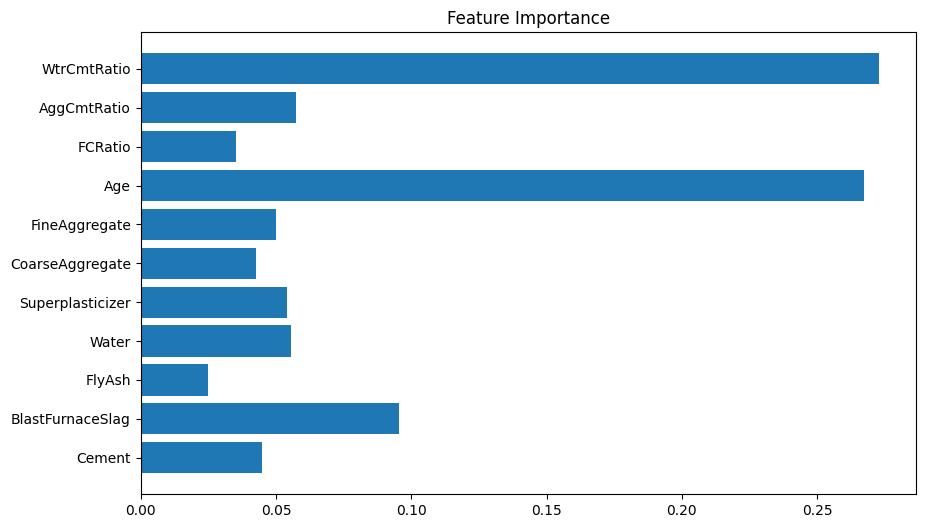

In [4]:
# Fit model to evaluate feature importance
model.fit(X, y)
importances = model.feature_importances_

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(X.columns, importances)
plt.title("Feature Importance")
plt.show()


#### Example 2: Mutual Information for Feature Selection

In cases where you have many features, it’s often helpful to use feature selection techniques to identify the most important features. We can use mutual information to measure the relationship between each feature and the target variable. Unlike correlation, mutual information can detect any kind of relationship, not just linear ones.

Step 1: Load the Car Dataset

We'll work with a dataset containing various attributes of cars and their prices. We'll use mutual information to rank the features by their relevance to the target variable.

In [5]:
# Load the car dataset
df = pd.read_csv("autos.csv")
df.head()


,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,audi,gas,std,4,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,2,audi,gas,std,4,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


Step 2: Preprocessing

Before calculating mutual information, we need to preprocess the dataset, including handling categorical variables. We encode categorical variables using label encoding.

In [6]:
# Encode categorical variables
X = df.copy()
y = X.pop("price")

# Label encoding for categorical features
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# Identify discrete features (categoricals)
discrete_features = X.dtypes == int


Step 3: Calculate Mutual Information

We now calculate the mutual information between each feature and the target variable (price), which is continuous.

In [7]:
from sklearn.feature_selection import mutual_info_regression

# Calculate mutual information scores
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # Show a few features with their MI scores


curb_weight          1.487673
highway_mpg          0.952699
length               0.609095
bore                 0.482940
stroke               0.375623
num_of_cylinders     0.331844
compression_ratio    0.133198
fuel_type            0.047279
Name: MI Scores, dtype: float64

Step 4: Visualizing Mutual Information

We can visualize the mutual information scores with a horizontal bar plot to compare the features' relevance to the target.

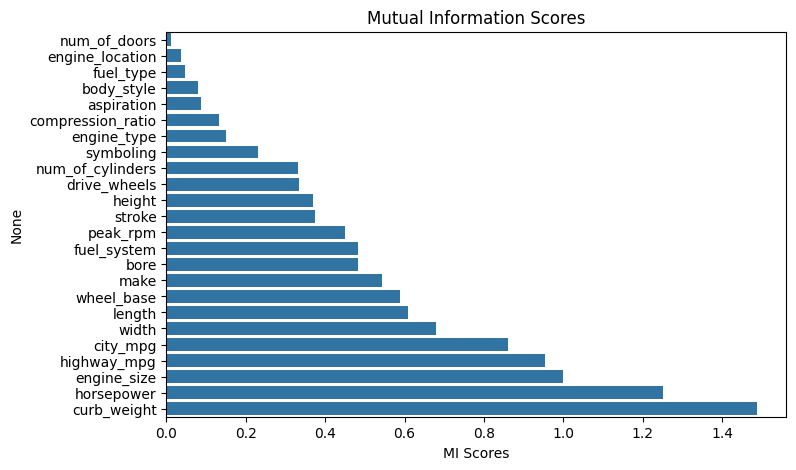

In [8]:
import seaborn as sns

# Plot MI scores
plt.figure(dpi=100, figsize=(8, 5))
mi_scores_sorted = mi_scores.sort_values(ascending=True)
sns.barplot(x=mi_scores_sorted, y=mi_scores_sorted.index)
plt.title("Mutual Information Scores")
plt.show()


Step 5: Visual Exploration of High-MI Features

To gain deeper insights, we can plot some of the high-scoring features against the target variable.



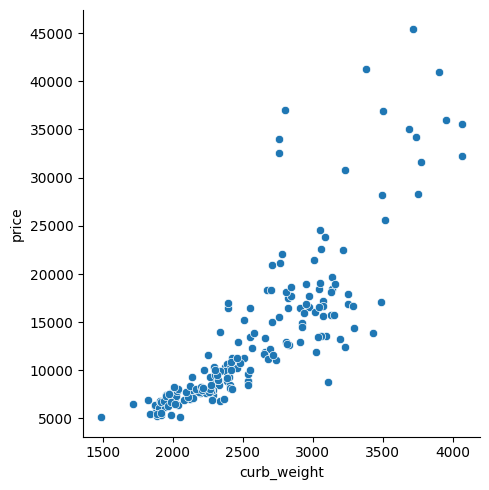

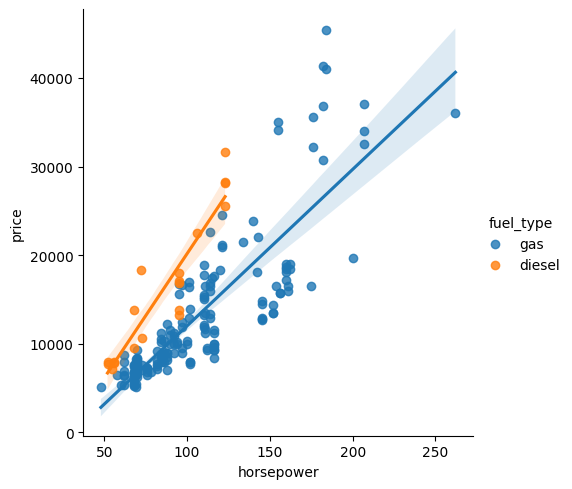

In [9]:
# Visualize high-MI features
sns.relplot(x="curb_weight", y="price", data=df)
sns.lmplot(x="horsepower", y="price", hue="fuel_type", data=df)


### Conclusion

Feature engineering is a crucial step in improving the performance of machine learning models. By adding new features, such as ratios, and using feature selection techniques like mutual information, we can significantly enhance the model's ability to make predictions.

In this notebook, we demonstrated feature engineering using two examples:

    Concrete compressive strength prediction using synthetic features.
    Car price prediction using mutual information to identify important features.

Feature engineering is often an iterative process, where you experiment with different transformations and evaluate their impact on model performance.
